In [1]:
# Tell Jupyter where to find the code
import os, sys
sys.path.append(os.environ['CODE']) #CODE is defined in the conda environment "Notes"
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
plt.style.use('notebook')
import matplotlib.cm as cm
import graphene, Emitter
import Electrodynamics as em
import Materials
import fundamental_constants as fc
import statistical_distributions as sd

In [2]:
from importlib.machinery import SourceFileLoader
if sys.platform=='linux': # Linux
    lumapi_path='/opt/lumerical/fdtd/api/python/lumapi.py'
if sys.platform in ('win32','win64'): # Windows
    lumapi_path=os.path.join('C:','\Program Files','Lumerical','FDTD','api','python','lumapi.py')
if sys.platform=='darwin':
    pass
lumapi=SourceFileLoader("lumapi",lumapi_path).load_module()

<a class='anchor' id='toc'/>

[1. Plasmon Dispersion in Graphene](#plasmon-dispersion-graphene)

&ensp;[a. Full Dispersion Relation](#full-dispersion-relation)

&ensp;[b. Nonretarded Limit](#nonretarded-limit)

&ensp;[c. Resonance Width](#plasmon-width)

&ensp;[d. Frequency Change with Fermi Level](#freq-change-w-fermi-level)

[2. On Various Substrates](#on-various-substrates)
   
&ensp;[a. Constant Permittivity](#substrate-constant)

&ensp;[b. Silicon Carbide](#graphene-on-sic)

&ensp;[c. Hexagonal Boron Nitride](#graphene-on-hbn)

&ensp;[d. Two Graphene Sheets](#graphene-two-sheets)

[2. Plasmon Excitation](#plasmon-excitation)

&ensp;[a. TM Fresnel Coefficient](#tm-fresnel)

[3. Light-Matter Interactions](#lm-int)

&ensp;[a. Decay Rate Enhancement](#decayrate)

[4. Comparison to FDTD](#fdtd)

# 1. Plasmon Dispersion in Graphene <a class='anchor' id='plasmon-dispersion-graphene'/>

[top](#toc)

## a. Full Dispersion Relation <a class='anchor' id='full-dispersion-relation'/>

[top](#toc)

The dispersion relation is the energy as a function of momentum $\omega(q)$. As described in [Christensen 2017 5.2.2](http://link.springer.com/10.1007/978-3-319-48562-1), the TM dispersion relation for any two-dimensional material between two dielectrics can be derived by matching boundary conditions of fields decaying exponentially away from the material. The result is
$$
\frac{\epsilon^-}{\sqrt{q^2-\epsilon^-(\omega/c)^2}}+\frac{\epsilon^+}{\sqrt{q^2-\epsilon^+(\omega/c)^2}}=\frac{\sigma(q,\omega)}{i\epsilon_0\omega}
$$

where $\sigma$ is the 2D conductivity. To find the dispersion relation requires numerically solving for $\omega$ given $q$. 

At this point, one can choose two viewpoints. On one hand, the frequency $\omega$ can be chosen to be real and the wavevector is complex $q=q_1+iq_2$. On the other hand, the wavevector can be chosen to be real $q=q^*$ with the frequency complex $\omega=\omega_1+i\omega_2$. We will usually choose the latter, since we are interested in resonances with finite width.

We therefore need to find the root of the equation

$$
f(\omega)=\frac{\epsilon^-}{\sqrt{(qc/\omega)^2-\epsilon^-}}+\frac{\epsilon^+}{\sqrt{(qc/\omega)^2-\epsilon^+}}-\frac{\sigma(q,\omega)}{i\epsilon_0c}
$$

We do this by mimimizing $||f(\omega_1+i\omega_2)||$ treating $\omega_1$ and $\omega_2$ as independent variables

In [14]:
mlg = graphene.Monolayer()
eps1 = 1
eps2 = 1
gamma=0.012 * fc.e_proton /fc.hbar
eF = 0.4* fc.e_proton

sigma = lambda kp,w: mlg.OpticalConductivity(kp,w,gamma,eF,0)

graphenestart = lambda q: [q *mlg.vF, q*mlg.vF/10]
start=graphenestart

kF = mlg.kFermi(eF,model='LowEnergy')
q = np.linspace(0.01,3,num=250) * kF

qdisp,disp= em.PlasmonDispersionRelation(q,1,1,sigma,
                                         start,
                                         valid_only=False,display=False)

Now get the Fresnel coefficients to show that they align with the plasmon dispersion.

In [15]:
omega_fresnel=np.linspace(0.01,3,num=450)*eF /fc.hbar
q_fresnel = np.linspace(0.01,3,num=450) * kF

eps=np.array([1,1])
d = np.array([-1,-1])
sigma=np.array([sigma])

R,T = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,eps,sigma,d,pol='p')

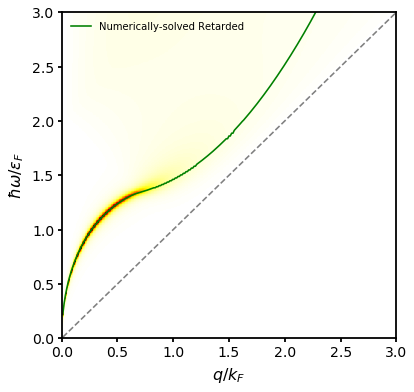

In [16]:
fig, dispax = plt.subplots(figsize=(6,6))

# Only plotting the negative to invert the colormap
dispax.imshow(-np.imag(np.transpose(R)),
              extent=(q_fresnel[0]/kF,q_fresnel[-1]/kF,fc.hbar*omega_fresnel[0]/eF,fc.hbar*omega_fresnel[-1]/eF),
              origin='lower',aspect='auto',cmap=cm.hot,vmin=-16,vmax=0)

dispax.plot(qdisp/kF,fc.hbar*disp[:,0]/eF,color='g',label='Numerically-solved Retarded')
dispax.plot(q/kF,q/kF,color='gray',linestyle='--')
dispax.set_xlabel('$q/k_F$')
dispax.set_ylabel('$\hbar\omega/\epsilon_F$')
dispax.set_ylim(0,3)
dispax.set_xlim(0,3)

plt.legend()
plt.show()

Various Fermi levels

In [3]:
mlg = graphene.Monolayer()
graphenestart = lambda q: [q *mlg.vF, q*mlg.vF/10]
start=graphenestart
eps1 = 1
eps2 = 1
mobility=1
T=0
#eFarray = np.array([0.05,0.2,0.4,0.6,0.8,1.0])* fc.e_proton
eFarray= np.array([0.3,0.5,0.7])*fc.e_proton

q = np.linspace(0.01,3,num=250) * mlg.kFermi(0.4*fc.e_proton,model='LowEnergy')

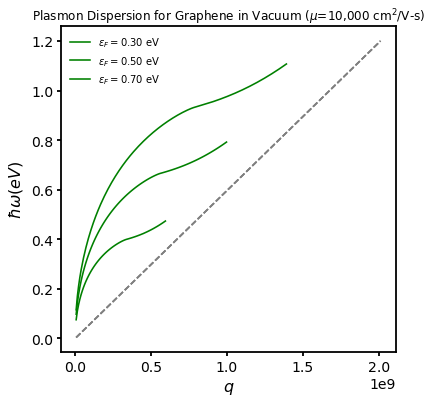

In [4]:
fig, dispax = plt.subplots(figsize=(6,6))

for eF in eFarray:
    gamma = mlg.ScatteringRate(mobility,eF)
    sigma = lambda kp,w: mlg.OpticalConductivity(kp,w,gamma,eF,T)
    qdisp,disp= em.PlasmonDispersionRelation(q,1,1,sigma,
                                             start,
                                             valid_only=True,display=False)
    dispax.plot(qdisp,fc.hbar*disp[:,0]/fc.e_proton,color='g',label='$\epsilon_F=$%.2f eV' % (eF/fc.e_proton))
    dispax.plot(q,fc.hbar*q*mlg.vF/fc.e_proton,color='gray',linestyle='--')
    dispax.set_xlabel('$q$')
    dispax.set_ylabel('$\hbar\omega (eV)$')

plt.title('Plasmon Dispersion for Graphene in Vacuum ($\mu$=10,000 cm$^2$/V-s)')
plt.legend()
plt.show()


## b. Nonretarded Limit <a class='anchor' id='nonretarded-limit'/>

[top](#toc)

As described in [Christensen 2017 5.2.2](http://link.springer.com/10.1007/978-3-319-48562-1), we usually solve the dispersion relation in the nonretarded limit $q\gg k_0$ where it is given by
$$
    \omega = \frac{\sigma(q,\omega)}{2i\epsilon_0\bar\epsilon}q
$$

Most of the time, $\sigma$ is complicated, so we have to solve the above equation numerically. That is, given $q=q_1+iq_2$ find the value of $\omega$ such that

$$
\boxed{
1 - \frac{\sigma(q,\omega)q}{2i\epsilon_0\bar\epsilon\omega} = 0
}
$$

If losses are small ($q_2\ll q_1$), we solve

$$
1-\frac{i\text{Im}[\sigma(q,\omega)]}{2i\epsilon_0\bar\epsilon\omega}=0
$$

Notice that since $q$ is large, this is a highly nonlocal limit. Therefore for large enough $q$, we must use the nonlocal conductivity. But we can still make some good approximations in the regime of low $q_1$. Using the intraband approximation for the conductivity, we get

$$
\omega = \frac{1}{\hbar}\sqrt{\frac{e^2\epsilon_F}{2\pi\epsilon_0\bar\epsilon}q}
$$

Below we show how to compute these dispersions with the provided code. For comparison to [Christensen 2017](http://link.springer.com/10.1007/978-3-319-48562-1), we include the Fresnel coefficient which also shows the location of the resonant frequency.

In [ ]:
mlg = graphene.Monolayer()
eps1 = 1
eps2 = 1
gamma=0.012 * fc.e_proton /fc.hbar
T=0
eF = 0.4 * fc.e_proton
kF = mlg.kFermi(eF,model='LowEnergy')
q = np.linspace(0.001,3,num=200) * kF

plas_disp_intra = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='intra')
plas_disp_local = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='local')
plas_disp_nonlocal = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='nonlocal')

omega_fresnel=np.linspace(0.01,3,num=450)*eF /fc.hbar
q_fresnel = np.linspace(0.01,3,num=450) * kF

fresnelTM=mlg.FresnelReflection(q_fresnel,omega_fresnel[:,np.newaxis],gamma,eF,T,eps1,eps2,'TM')

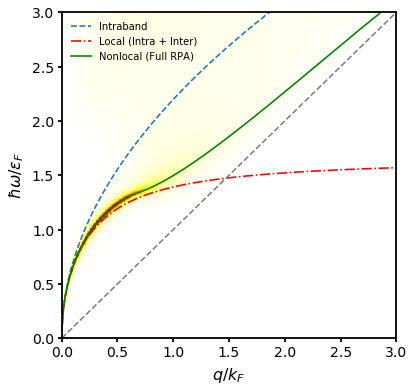

In [23]:
fig, dispax = plt.subplots(figsize=(6,6))

# Only plotting the negative to invert the colormap
dispax.imshow(-np.imag(fresnelTM),
              extent=(q_fresnel[0]/kF,q_fresnel[-1]/kF,fc.hbar*omega_fresnel[0]/eF,fc.hbar*omega_fresnel[-1]/eF),
              origin='lower',aspect='auto',cmap=cm.hot,vmin=-16,vmax=0)

dispax.plot(q/kF,fc.hbar*plas_disp_intra/eF,'--',label='Intraband')
dispax.plot(q/kF,fc.hbar*plas_disp_local/eF,'r-.',label='Local (Intra + Inter)')
dispax.plot(q[:190]/kF,fc.hbar*plas_disp_nonlocal[:190]/eF,'g',label='Nonlocal (Full RPA)')
dispax.plot(q/kF,q/kF,color='gray',linestyle='--')
dispax.set_xlabel('$q/k_F$')
dispax.set_ylabel('$\hbar\omega/\epsilon_F$')
dispax.set_ylim(0,3)
dispax.set_xlim(0,3)

plt.legend()
plt.show()

The results are consistent with [Christensen 2017 5.2.2](http://link.springer.com/10.1007/978-3-319-48562-1).

<img src='images/christensen-thesis-2017-fig5-2.png' width='450px'/>

## c. Resonance Width<a class='anchor' id='plasmon-width'/>

[top](#toc)

A plasmon is a resonance in an imperfect material, and therefore has some loss associated with it, both from the losses intrinsic to the conductivity of graphene and scattering from impurities. This leads to a finite width to the resonance. We can compute this width by fitting the imaginary part of the Fresnel reflection coefficient to a Lorentzian peak.

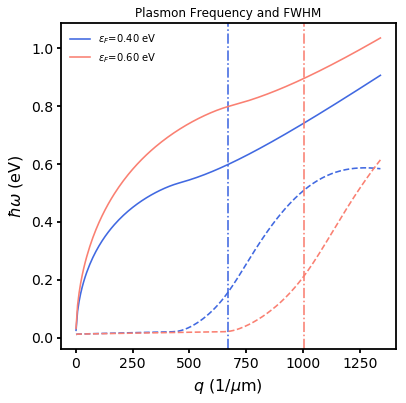

In [6]:
mlg = graphene.Monolayer()
eps1 = 1
eps2 = 1
gamma=0.012 * fc.e_proton /fc.hbar
T=0
EF = np.array([0.4,0.6]) * fc.e_proton
kF = mlg.kFermi(EF[0],model='LowEnergy')
q = np.linspace(0.001,2,num=200) * kF

fig, dispax = plt.subplots(figsize=(6,6))
colors=['royalblue','salmon',]
for i, eF in np.ndenumerate(EF):
    c=colors[i[0]]
    disp = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='nonlocal')
    width= mlg.PlasmonDispersionRes(q,gamma,eF,eps1,eps2,T)[:,1]
    dispax.plot(q*1e-6,fc.hbar*disp/fc.e_proton,label='$\epsilon_F$=%.2f eV' % (eF/fc.e_proton),color=c)
    dispax.plot(q*1e-6,fc.hbar*width/fc.e_proton,linestyle='--',color=c)
    
    kF0 = mlg.kFermi(eF,model='LowEnergy')
    dispax.axvline(kF0*1e-6,0,1,color=c,linestyle='-.')
    
dispax.set_xlabel('$q$ (1/$\mu$m)')
dispax.set_ylabel('$\hbar\omega$ (eV)')

plt.title('Plasmon Frequency and FWHM')
plt.legend()
plt.show()

# 2. On Various Substrates <a class='anchor' id='on-various-substrates'/>

[top](#toc)

## a. Constant Permittivity <a class='anchor' id='substrate-constant'/>
    
[top](#toc)

We look briefly at the influence of the dielectric environment on graphene plasmons, but only consider lossless, constant permittivities. Below, we place graphene on a substrate with $\epsilon=4$. We can see it lowers the energy.

In [8]:
mlg = graphene.Monolayer()

eps1 = 1
eps_vac = 1
eps_hbn = 4
eF = 0.4 * fc.e_proton
gamma=0.012*fc.e_proton/fc.hbar
T=0
sigmaGr = lambda kp,w: mlg.OpticalConductivity(kp,w,gamma,eF,T)
startGr = lambda q: [q *mlg.vF, q*mlg.vF/10]
kF = mlg.kFermi(eF,model='LowEnergy')
q = np.linspace(0.01,2,num=200) * kF

plas_disp_vac_intra = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps_vac,T,model='intra')
plas_disp_hbn_intra = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps_hbn,T,model='intra')

q_vac, disp_vac = em.PlasmonDispersionRelation(q,eps1,eps_vac,sigma=sigmaGr,
                                              start=startGr,valid_only=False)

q_hbn, disp_hbn = em.PlasmonDispersionRelation(q,eps1,eps_hbn,sigma=sigmaGr,
                                              start=startGr, valid_only=False)

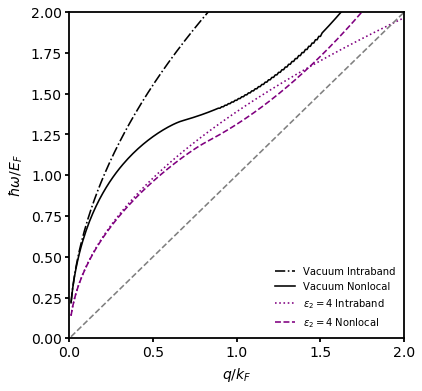

In [11]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(q/kF,fc.hbar*plas_disp_vac_intra/eF,linestyle='-.',color='black',label='Vacuum Intraband')
ax.plot(q_vac/kF,fc.hbar*disp_vac[:,0]/eF,'k',label='Vacuum Nonlocal')
ax.plot(q/kF,fc.hbar*plas_disp_hbn_intra/eF,linestyle='dotted',color='purple',label='$\epsilon_2=4$ Intraband')
ax.plot(q_hbn/kF,fc.hbar*disp_hbn[:,0]/eF,linestyle='dashed',color='purple',label='$\epsilon_2=4$ Nonlocal')
ax.plot(q/kF,q/kF,color='gray',linestyle='--')
ax.set_ylim(0,2)
ax.set_xlim(0,2)

plt.xlabel('$q/k_F$',fontsize=14)
plt.ylabel('$\hbar\omega/E_F$',fontsize=14)

plt.legend()
plt.show()

Compare to Figure 1d of [Jablan et al. 2009](https://link.aps.org/doi/10.1103/PhysRevB.80.245435)

<img src='images/jablan-plasmonics-2009-fig2d.png' />

## b. Silicon Carbide <a class='anchor' id='graphene-on-sic' />

[top](#toc)

Define the materials and parameters.

In [2]:
SiC = Materials.SiliconCarbide()
epsSiC = lambda q,w: SiC.Permittivity(0,w)

mlg = graphene.Monolayer()
eF = 0.2*fc.e_proton
gamma = 1e-13
sigmaGr = lambda kp,w: mlg.OpticalConductivity(kp,w,gamma,eF,0)
startGr = lambda q: [q *mlg.vF, q*mlg.vF/10]

eps1 = 1
eps2 = epsSiC
T=0
q = np.linspace(0.01,100,num=200) * 1e6

The easy stuff. Bare SiC, and bare graphene.

In [3]:
# Bare Silicon Carbide Dispersion
qBareSiC, BareSiC = em.PlasmonDispersionRelation(q,1,epsSiC,sigma=0,
                                           start=lambda q: [SiC.wspp,1e12],
                                           valid_only=True,display=False)

# Bare Graphene Dispersion
qBareGr, BareGr = em.PlasmonDispersionRelation(q,1,1,sigma=sigmaGr,
                                                start=startGr,
                                                valid_only=True,display=False)

The lower branch of Graphene on SiC

In [4]:
startlower = lambda q: [q *mlg.vF, q*mlg.vF/10]
qGrSiC_lower, GrSiC_lower = em.PlasmonDispersionRelation(q,1,epsSiC,sigma=sigmaGr,
                                            start=startlower,
                                            valid_only=True,display=False)

The upper branch

In [5]:
startupper = lambda q: [SiC.wspp,0.1*SiC.wspp]
qGrSiC_upper, GrSiC_upper = em.PlasmonDispersionRelation(q,1,epsSiC,sigma=sigmaGr,
                                                        start=startupper,
                                                        valid_only=True,display=False)

Now get the FresnelReflection coefficient.

In [6]:
qfresnel = np.linspace(1e-4,100,num=300)*1e6
omegafresnel=np.linspace(1e-5,5,num=300)*1e14
eps=np.array([1,epsSiC])
d = np.array([-1,-1])
sigma=np.array([sigmaGr])

R,T = em.FresnelCoefficientStack(qfresnel,omegafresnel,eps,sigma,d,pol='p')

Now plot them all together

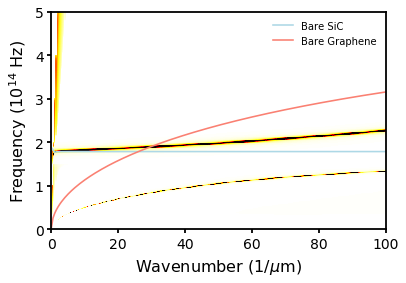

In [8]:
plt.plot(qBareSiC*1e-6,BareSiC[:,0]*1e-14,label='Bare SiC',color='lightblue')
plt.plot(qBareGr*1e-6, BareGr[:,0]*1e-14, label='Bare Graphene',color='salmon')
# plt.plot(qGrSiC_lower*1e-6, GrSiC_lower[:,0]*1e-14, label='Graphene on SiC',color='royalblue',linestyle='--')
# plt.plot(qGrSiC_upper*1e-6, GrSiC_upper[:,0]*1e-14, color='royalblue',linestyle='--')
plt.imshow(-np.imag(np.transpose(R)),
              extent=(qfresnel[0]*1e-6,qfresnel[-1]*1e-6,omegafresnel[0]*1e-14,omegafresnel[-1]*1e-14),
              origin='lower',aspect='auto',cmap=cm.hot,vmin=-2,vmax=0)
plt.ylim(0,5)
plt.xlabel('Wavenumber (1/$\mu$m)')
plt.ylabel('Frequency ($10^{14}$ Hz)')
plt.legend()
plt.show()

Compare this to the middle plot of the below figure.

<img src='images/messina-tuning-2013-Fig3.png' width='450px'/>

## c. Hexagonal Boron Nitride <a class='anchor' id='graphene-on-hbn'/>

[top](#toc)

## d. Two Sheets <a class='anchor' id='graphene-two-sheets'/>

[top](#toc)

Define the materials and parameters.

In [3]:
mlg0 = graphene.Monolayer()
mlg1 = graphene.Monolayer()
mlg2 = graphene.Monolayer()
mlg3 = graphene.Monolayer()
eF0, eF1, eF2, eF3 = 0.7*fc.e_proton,0.6*fc.e_proton, 0.5*fc.e_proton, 0.4*fc.e_proton

# gamma = 1e-13
gamma = 0.012 *fc.e_proton/fc.hbar 
sigma0 = lambda kp,w: mlg0.OpticalConductivity(kp,w,gamma,eF0,0)
sigma1 = lambda kp,w: mlg1.OpticalConductivity(kp,w,gamma,eF1,0)
sigma2 = lambda kp,w: mlg2.OpticalConductivity(kp,w,gamma,eF2,0)
sigma3 = lambda kp,w: mlg3.OpticalConductivity(kp,w,gamma,eF3,0)

eps = np.array([1,1,1])
d = np.array([-1,10e-9,-1])
sigma10=np.array([sigma1,sigma0])
sigma11=np.array([sigma1,sigma1])
sigma12=np.array([sigma1,sigma2])
sigma13=np.array([sigma1,sigma3])
sigma22=np.array([sigma2,sigma2])

Now get the FresnelReflection coefficient.

In [4]:
omega_fresnel=np.linspace(0.01,18,num=200)* 1e14
q_fresnel = np.linspace(0.01,1200,num=200) * 1e6

In [5]:
R10,T10 = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,eps,sigma10,d,pol='p')

In [6]:
R12,T12 = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,eps,sigma12,d,pol='p')

In [7]:
R13,T13 = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,eps,sigma13,d,pol='p')

In [8]:
R22,T22 = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,eps,sigma22,d,pol='p')

In [9]:
R11,T11 = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,eps,sigma11,d,pol='p')

In [10]:
# Bare graphene monolayer1
R1,T1 = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,
                                   eps=np.array([1,1]),
                                   sigma=np.array([sigma1]),
                                   d=np.array([-1,-1]),pol='p')

# Bare graphene monolayer2
R2,T2 = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,
                                   eps=np.array([1,1]),
                                   sigma=np.array([sigma2]),
                                   d=np.array([-1,-1]),pol='p')

In [11]:
# Bare graphene monolayer3
R3,T3 = em.FresnelCoefficientStack(q_fresnel,omega_fresnel,
                                   eps=np.array([1,1]),
                                   sigma=np.array([sigma3]),
                                   d=np.array([-1,-1]),pol='p')

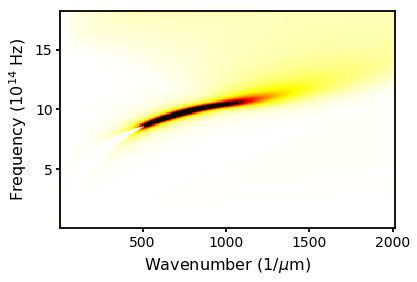

In [26]:
plt.imshow(-np.imag(np.transpose(R22)),
              extent=(q_fresnel[0]*1e-6,q_fresnel[-1]*1e-6,omega_fresnel[0]*1e-14,omega_fresnel[-1]*1e-14),
              origin='lower',aspect='auto',cmap=cm.hot,vmin=-5,vmax=0)

plt.xlabel('Wavenumber (1/$\mu$m)')
plt.ylabel('Frequency ($10^{14}$ Hz)')
#plt.title('Two graphene sheets ($\epsilon_{F,1}$=0.6 eV, $\epsilon_{F,2}$=0.6 eV separated by 100 nm)')
plt.show()

## d. Frequency change with Fermi Level <a class='anchor' id='freq-change-w-fermi-level'/>

[top](#toc)

There is a lot of interest in using graphene to tune the properties of optical devices. This technique relies on shifting the resonant frequency of graphene via its Fermi level.

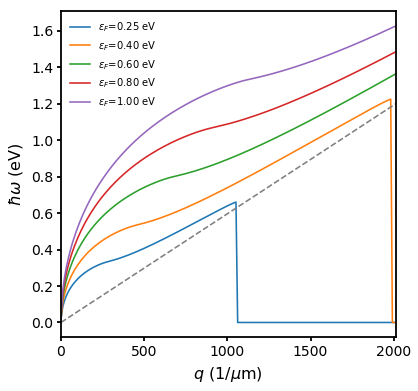

In [2]:
mlg = graphene.Monolayer()
eps1 = 1
eps2 = 1
gamma=0.012 * fc.e_proton /fc.hbar
T=0
EF = np.array([0.25,0.4,0.6,0.8,1]) * fc.e_proton

kF = mlg.kFermi(EF[1],model='LowEnergy')

q = np.linspace(0.001,3,num=200) * kF

fig, dispax = plt.subplots(figsize=(6,6))

for eF in EF:
    disp = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='nonlocal')

    dispax.plot(q*1e-6,fc.hbar*disp/fc.e_proton,label='$\epsilon_F$=%.2f eV' % (eF/fc.e_proton))

dispax.plot(q*1e-6,fc.hbar*q*mlg.vF/fc.e_proton,color='gray',linestyle='--')
dispax.set_xlim(0,q[-1]*1e-6)
dispax.set_xlabel('$q$ (1/$\mu$m)')
dispax.set_ylabel('$\hbar\omega$ (eV)')


plt.title('')
plt.legend()
plt.show()

We may be interested in $d\omega/d\epsilon_F$ where $\omega$ is the resonance frequency and $\epsilon_F$ is the Fermi level.

3.2043520000000003e-20
6.408704000000001e-20
9.613056e-20
1.201632e-19


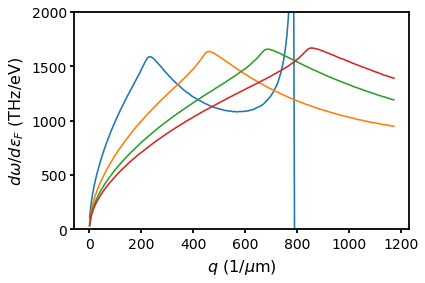

In [4]:
mlg = graphene.Monolayer()
eps1 = 1
eps2 = 1
gamma=0.012 * fc.e_proton /fc.hbar
T=0
EF = np.array([0.2,0.4,0.6,0.75]) * fc.e_proton
kF = mlg.kFermi(eF,model='LowEnergy')
q = np.linspace(0.001,3.5,num=200) * kF

for eF in EF:
    print(eF)
    domega=mlg.dPlasmonDispersion(q,gamma,eF,
                                  eps1,eps2,T,
                                  model='nonlocal',
                                  dvar='eFermi',diff=1e-5)

    plt.plot(q*1e-6,domega*fc.e_proton/1e12)

plt.xlabel('$q$ (1/$\mu$m)')
plt.ylabel('$d\omega/d\epsilon_F$ (THz/eV)')
plt.ylim(0,2000)
plt.show()

It makes more sense to talk about the change in resonant frequency normalized by the width of the resonance. 

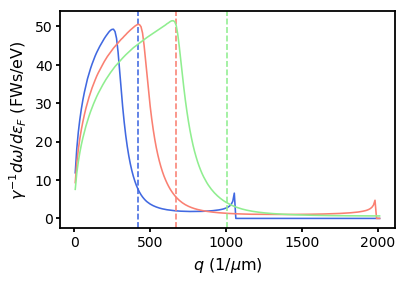

In [6]:
mlg = graphene.Monolayer()
eps1 = 1
eps2 = 1
gamma=0.012 * fc.e_proton /fc.hbar
T=0
EF = np.array([0.25,0.4,0.6]) * fc.e_proton
kF = mlg.kFermi(0.4*fc.e_proton,model='LowEnergy')
q = np.linspace(0.01,3,num=200) * kF
colors=['royalblue','salmon','lightgreen']

for i,eF in np.ndenumerate(EF):
    c = colors[i[0]]
    domega=mlg.dPlasmonDispersion(q,gamma,eF,
                                  eps1,eps2,T,
                                  model='nonlocal',
                                  dvar='eFermi',diff=1e-5)
    width= mlg.PlasmonDispersionRes(q,gamma,eF,eps1,eps2,T)[:,1]
    plt.plot(q*1e-6,(domega/width)*fc.e_proton,color=c)
    
    kF0 = mlg.kFermi(eF,model='LowEnergy')
    plt.axvline(kF0*1e-6,0,1,color=c,linestyle='--')
    
plt.xlabel('$q$ (1/$\mu$m)')
plt.ylabel('$\gamma^{-1}d\omega/d\epsilon_F$ (FWs/eV)')

plt.show()

# 3. Light-Matter Interactions <a class='anchor' id='lm-int'/>

[top](#toc)

## a. Decay Rate Enhancement <a class='anchor' id='decayrate'/>

[top](#toc)

[Koppens 2014](https://doi.org/10.1021/nl201771h)

$$
\Gamma = \Gamma_0 + \frac{1}{\hbar}\int_0^\infty dk_{||} k_{||}\text{Re}\left\{ \left[|\mathbf d_{||}|^2(k_0^2r_s-k_\perp^2 r_p) + 2|\mathbf d_\perp|^2k_{||}^2r_p\right]\frac{e^{2ik_\perp z}}{k_\perp} \right\}
$$

Ignoring parallel components of dipole

$$
\Gamma = \Gamma_0 + \frac{1}{\hbar}\int_0^\infty dk_{||} k_{||}\text{Re}\left\{ \left[2|\mathbf d_\perp|^2k_{||}^2r_p\right]\frac{e^{2ik_\perp z}}{k_\perp} \right\}
$$

$$
k_\perp = \sqrt{\epsilon_1(\omega/c)^2 - k_{||}^2}
$$

In [ ]:
mlg = Graphene.Monolayer()
dp = Emitter.Dipole()
omega = np.logspace(-1,np.log10(2.5),num=200)*fc.e_proton / fc.hbar
gamma = 1 / (5000 * 1e-15)
eps1,eps2 = 1, 2
z = 10e-9
T=0

decayrate_high = mlg.DipoleDecayRate(z,omega,gamma,1*fc.e_proton,
                                     T,eps1,eps2)
decayrate_low  = mlg.DipoleDecayRate(z,omega,gamma,0.2*fc.e_proton,
                                     T,eps1,eps2)

decayrate0= dp.DecayRate(omega,np.array([0,0,1]))

C:\Users\User\Documents\Research\Notes\code\Graphene.py:785: UserWarning: Monolayer.DipoleDecayRate: Ignoring dipole components in xy-plane
  warnings.warn('Monolayer.DipoleDecayRate: Ignoring dipole components in xy-plane')


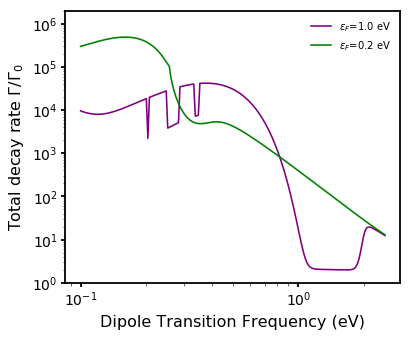

In [4]:
fig, ax = plt.subplots(figsize=(6,5))
ax.loglog(fc.hbar*omega/fc.e_proton,
          decayrate_high/decayrate0,
          color='purple',
          label='$\epsilon_F$=%.1f eV' % (1))
ax.loglog(fc.hbar*omega/fc.e_proton,
          decayrate_low/decayrate0,
          color='green',
          label='$\epsilon_F$=0.2 eV')
ax.set_xlabel('Dipole Transition Frequency (eV)')
ax.set_ylabel('Total decay rate $\Gamma/\Gamma_0$')
ax.set_ylim(1e0,2e6)

plt.legend()
plt.show()

<img src='images/koppens-graphene-2011-figS2.png' width='600px'/>

# Obsolete

[top](#toc)

## c. Fresnel Coefficients

[top](#toc)

It is also possible to find the dispersion from fitting to the poles of the $p$-polarized Fresnel coefficient.

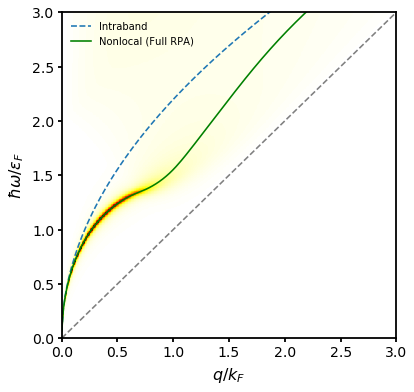

In [2]:
mlg = graphene.Monolayer()
eps1 = 1
eps2 = 1
gamma=0.012 * fc.e_proton /fc.hbar
T=0
eF = 0.4 * fc.e_proton
kF = mlg.kFermi(eF,model='LowEnergy')
q = np.linspace(0.001,3,num=200) * kF

plas_disp_intra = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='intra')
plas_fit=mlg.PlasmonDispersionRes(q,gamma,eF,eps1,eps2,T)
plas_disp_nonlocal=plas_fit[:,0]

omega_fresnel=np.linspace(0.01,3,num=450)*eF /fc.hbar
q_fresnel = np.linspace(0.01,3,num=450) * kF

fresnelTM=mlg.FresnelReflection(q_fresnel,omega_fresnel[:,np.newaxis],gamma,eF,T,eps1,eps2,'TM')

fig, dispax = plt.subplots(figsize=(6,6))

# Only plotting the negative to invert the colormap
dispax.imshow(-np.imag(fresnelTM),
              extent=(q_fresnel[0]/kF,q_fresnel[-1]/kF,fc.hbar*omega_fresnel[0]/eF,fc.hbar*omega_fresnel[-1]/eF),
              origin='lower',aspect='auto',cmap=cm.hot,vmin=-16,vmax=0)

dispax.plot(q/kF,fc.hbar*plas_disp_intra/eF,'--',label='Intraband')

dispax.plot(q/kF,fc.hbar*plas_disp_nonlocal/eF,'g',label='Nonlocal (Full RPA)')
dispax.plot(q/kF,q/kF,color='gray',linestyle='--')
dispax.set_xlabel('$q/k_F$')
dispax.set_ylabel('$\hbar\omega/\epsilon_F$')
dispax.set_ylim(0,3)
dispax.set_xlim(0,3)

plt.legend()
plt.show()

# Comparison to FDTD

We compare theory with FDTD bandstructure calculations.

In [3]:
fdtd=lumapi.FDTD('fdtd/bandstructure.fsp')
bs=fdtd.getsweepresult('Gamma-X','spectrum')
ax=fdtd.getnamed('::model','ax')
bs['kx']=bs['kx'].squeeze()*(2*fc.pi/ax)
bs['f']=bs['f'].squeeze()

In [4]:
bs['f']

array([5.50000000e+10, 1.65011002e+11, 2.75022004e+11, ...,
       5.49779978e+14, 5.49889989e+14, 5.50000000e+14])

In [10]:
mlg = graphene.Monolayer()
eps1 = 1
eps2 = 1
gamma=0.012 * fc.e_proton /fc.hbar
T=0
eF = 0.4 * fc.e_proton
kF = mlg.kFermi(eF,model='LowEnergy')
q = np.linspace(0.001,3,num=200) * kF

plas_disp_intra = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='intra')
plas_disp_local = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='local')
plas_disp_nonlocal = mlg.PlasmonDispersion(q,gamma,eF,eps1,eps2,T,model='nonlocal')

In [40]:
(kF/2*fc.pi)**(-1)

9.492000806271937e-10

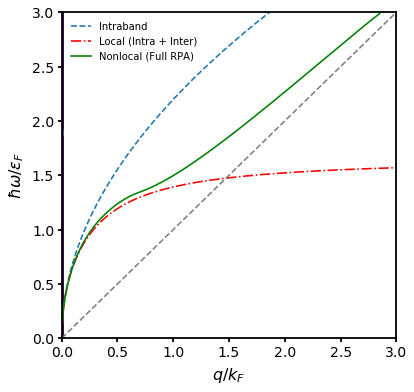

In [34]:
fig, dispax = plt.subplots(figsize=(6,6))

plt.imshow(bs['fs'],aspect='auto',extent=[bs['kx'][0]/kF,
                                          bs['kx'][-1]/kF,
                                          bs['f'][0]*2*fc.pi*fc.hbar/eF,
                                          bs['f'][-1]*2*fc.pi*fc.hbar/eF])

dispax.plot(q/kF,fc.hbar*plas_disp_intra/eF,'--',label='Intraband')
dispax.plot(q/kF,fc.hbar*plas_disp_local/eF,'r-.',label='Local (Intra + Inter)')
dispax.plot(q[:190]/kF,fc.hbar*plas_disp_nonlocal[:190]/eF,'g',label='Nonlocal (Full RPA)')
dispax.plot(q/kF,q/kF,color='gray',linestyle='--')
dispax.set_xlabel('$q/k_F$')
dispax.set_ylabel('$\hbar\omega/\epsilon_F$')
dispax.set_ylim(0,3)
dispax.set_xlim(0,3)

plt.legend()
plt.show()